# Rotating MNIST with Mixed Digits

# 0. Imports

In [94]:
from typing import Sequence
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import jacrev, vmap, jit
from jax.lax import scan, cond
from jax.flatten_util import ravel_pytree
import flax.linen as nn
from flax.training import train_state
from tqdm import trange
import optax
from bayes_opt import BayesianOptimization

from rebayes.utils.utils import MLP, get_mlp_flattened_params
from rebayes.utils import datasets
from dynamax.generalized_gaussian_ssm.models import ParamsGGSSM
from dynamax.generalized_gaussian_ssm.inference import EKFIntegrals, conditional_moments_gaussian_filter
from rebayes.orthogonal_recursive_filter.orfit import RebayesORFit
from rebayes.orthogonal_recursive_filter.orfit_inference import ORFitParams
from rebayes.base import RebayesParams

In [101]:
def plot_results(ax, result_dict, title, legend_loc=None):
    for key, val in result_dict.items():
        ax.plot(val['rmse'], color=val['color'], ls=val['ls'], label=key)
        ax.fill_between(
            jnp.arange(val['rmse'].shape[0]),
            val['rmse'] - 0.5*val['rmse_std'],
            val['rmse'] + 0.5*val['rmse_std'],
            alpha=0.1, color=val['color']
        )

    if legend_loc is not None:
        ax.legend(loc=legend_loc)
    ax.grid()
    ax.set_xlim(0, 2000)
    ax.set_ylim(0, 125)
    ax.set_xlabel('Training Steps (samples)')
    ax.set_ylabel('RMSE (deg)')
    ax.set_title(title)

    return ax

In [102]:
@partial(jit, static_argnums=(0,))
def compute_orfit_ppd_moments(apply_fn, x_to_pred, post_mean, post_basis):
    apply = lambda w: apply_fn(w, x_to_pred)

    # Compute posterior predictive mean
    pred_mean = apply(post_mean)

    # Compute posterior predictive covariance
    F = jacrev(apply)(post_mean)
    FU = F @ post_basis
    pred_cov = F @ F.T - FU @ FU.T

    return pred_mean, pred_cov

# 1. Load Dataset

In [97]:
# Load rotated MNIST dataset
np.random.seed(314)
num_train = 2_000
num_test = 2_000

train, test = datasets.load_rotated_mnist()
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

idx = jr.choice(jr.PRNGKey(0), X_train.shape[0], shape=(num_train,), replace=False)
# X_train = jnp.array(X_train)[:num_train]
# y_train = jnp.array(y_train)[:num_train]
X_train = jnp.array(X_train)[idx]
y_train = jnp.array(y_train)[idx]

test_idx = jr.choice(jr.PRNGKey(0), X_test.shape[0], shape=(num_test,), replace=False)
X_test = jnp.array(X_test)[test_idx]
y_test = jnp.array(y_test)[test_idx]

ix_sort = jnp.argsort(y_train)
X_train_inc = X_train[ix_sort]
y_train_inc = y_train[ix_sort]

X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

X_train_inc = (X_train_inc - X_train_inc.mean()) / X_train_inc.std()

In [108]:
# Define Linear Regression as single layer perceptron
input_dim, hidden_dims, output_dim = 784, [], 1
model_dims = [input_dim, *hidden_dims, output_dim]
_, flat_params, _, apply_fn = get_mlp_flattened_params(model_dims)
print(flat_params.shape)

(785,)


# 2. Angle Prediction

## 2.1 ORFit-Linear (Memory Size 10)

In [104]:
orfit_model_params = RebayesParams(
    initial_mean=flat_params,
    initial_covariance=None,
    dynamics_weights=None,
    dynamics_covariance=None,
    emission_mean_function=apply_fn,
    emission_cov_function=None,
)
orfit_params_linear = ORFitParams(
    memory_size=10,
    sv_threshold=0.0
)
orfit_estimator = RebayesORFit(orfit_model_params, orfit_params_linear, method='orfit')

orfit_train_rmses, orfit_train_stds = [], []
orfit_test_rmses, orfit_test_stds = [], []

orfit_bel = orfit_estimator.init_bel()
for i in trange(X_train_inc.shape[0]):
    # Update params
    orfit_bel = orfit_estimator.update_state(orfit_bel, X_train_inc[i], y_train_inc[i])

    # Train RMSE
    train_pred_mean, train_pred_cov = vmap(compute_orfit_ppd_moments, (None, 0, None, None))(apply_fn, X_train_inc, orfit_bel.mean, orfit_bel.basis)
    train_pred_mean, train_pred_cov = train_pred_mean.ravel(), train_pred_cov.ravel()
    train_rmse = jnp.sqrt(((train_pred_mean - y_train_inc)**2)).mean()
    train_std = jnp.sqrt(train_pred_cov).mean()
    orfit_train_rmses.append(train_rmse)
    orfit_train_stds.append(train_std)

    # Test RMSE
    test_pred_mean, test_pred_cov = vmap(compute_orfit_ppd_moments, (None, 0, None, None))(apply_fn, X_test, orfit_bel.mean, orfit_bel.basis)
    test_pred_mean, test_pred_cov = test_pred_mean.ravel(), test_pred_cov.ravel()
    test_rmse = jnp.sqrt(((test_pred_mean - y_test)**2)).mean()
    test_std = jnp.sqrt(test_pred_cov).mean()
    orfit_test_rmses.append(test_rmse)
    orfit_test_stds.append(test_std)

orfit_train_rmses, orfit_train_stds = jnp.array(orfit_train_rmses), jnp.array(orfit_train_stds)
orfit_test_rmses, orfit_test_stds = jnp.array(orfit_test_rmses), jnp.array(orfit_test_stds)

100%|██████████| 2000/2000 [00:10<00:00, 183.39it/s]


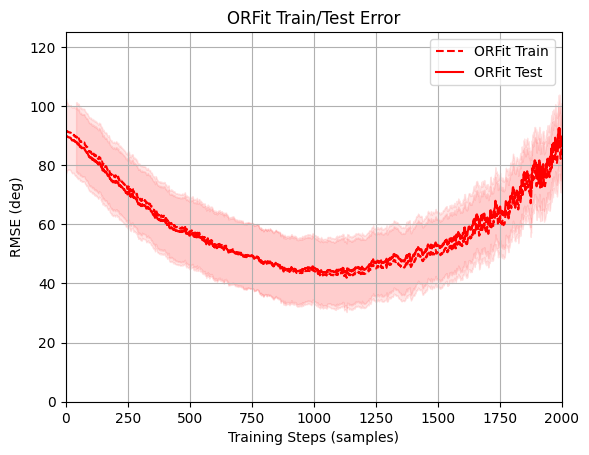

In [105]:
fig, ax = plt.subplots()
orfit_result_dict = {
    'ORFit Train': {
        'rmse': orfit_train_rmses,
        'rmse_std': orfit_train_stds,
        'color': 'r',
        'ls': '--',
    },
    'ORFit Test': {
        'rmse': orfit_test_rmses,
        'rmse_std': orfit_test_stds,
        'color': 'r',
        'ls': '-',
    }
}
ax = plot_results(ax, orfit_result_dict, 'ORFit Train/Test Error', legend_loc=1)

## 2.2 ORFit-Linear (Full Memory)

In [106]:
fm_orfit_params_linear = ORFitParams(
    memory_size=2_000,
    sv_threshold=0.0
)
fm_orfit_estimator = RebayesORFit(orfit_model_params, fm_orfit_params_linear, method='orfit')

fm_orfit_train_rmses, fm_orfit_train_stds = [], []
fm_orfit_test_rmses, fm_orfit_test_stds = [], []

fm_orfit_bel = fm_orfit_estimator.init_bel()
for i in trange(X_train_inc.shape[0]):
    # Update params
    fm_orfit_bel = fm_orfit_estimator.update_state(fm_orfit_bel, X_train_inc[i], y_train_inc[i])

    # Train RMSE
    train_pred_mean, train_pred_cov = vmap(compute_orfit_ppd_moments, (None, 0, None, None))(apply_fn, X_train_inc, fm_orfit_bel.mean, fm_orfit_bel.basis)
    train_pred_mean, train_pred_cov = train_pred_mean.ravel(), train_pred_cov.ravel()
    train_rmse = jnp.sqrt(((train_pred_mean - y_train_inc)**2)).mean()
    train_std = jnp.sqrt(train_pred_cov.mean())
    fm_orfit_train_rmses.append(train_rmse)
    fm_orfit_train_stds.append(train_std)

    # Test RMSE
    test_pred_mean, test_pred_cov = vmap(compute_orfit_ppd_moments, (None, 0, None, None))(apply_fn, X_test, fm_orfit_bel.mean, fm_orfit_bel.basis)
    test_pred_mean, test_pred_cov = test_pred_mean.ravel(), test_pred_cov.ravel()
    test_rmse = jnp.sqrt(((test_pred_mean - y_test)**2)).mean()
    test_std = jnp.sqrt(test_pred_cov.mean())
    fm_orfit_test_rmses.append(test_rmse)
    fm_orfit_test_stds.append(test_std)

fm_orfit_train_rmses, fm_orfit_train_stds = jnp.array(fm_orfit_train_rmses), jnp.array(fm_orfit_train_stds)
fm_orfit_test_rmses, fm_orfit_test_stds = jnp.array(fm_orfit_test_rmses), jnp.array(fm_orfit_test_stds)

100%|██████████| 2000/2000 [00:19<00:00, 104.31it/s]


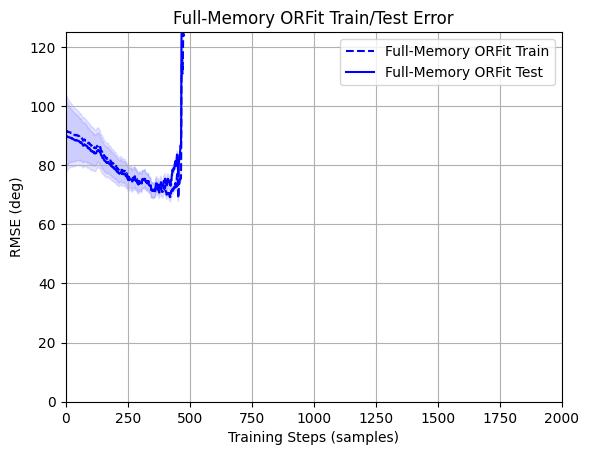

In [107]:
fig, ax = plt.subplots()
fm_orfit_result_dict = {
    'Full-Memory ORFit Train': {
        'rmse': fm_orfit_train_rmses,
        'rmse_std': fm_orfit_train_stds,
        'color': 'b',
        'ls': '--',
    },
    'Full-Memory ORFit Test': {
        'rmse': fm_orfit_test_rmses,
        'rmse_std': fm_orfit_test_stds,
        'color': 'b',
        'ls': '-',
    }
}
ax = plot_results(ax, fm_orfit_result_dict, 'Full-Memory ORFit Train/Test Error', legend_loc=1)

## 2.3 Bayesian ORFit (Memory Size 10)

### 2.3.1 Hyperparameter Tuning

In [115]:
model_dims_nl = [784, 100, 100, 1]
_, flat_params, _, apply_fn_rmnist = get_mlp_flattened_params(model_dims_nl)
apply_fn_rmnist = jit(apply_fn_rmnist)

def bayesian_orfit_opt_fn(log_init_cov, dynamics_weights, dynamics_cov, log_emission_cov):
    model_params_linear = RebayesParams(
        initial_mean=flat_params,
        initial_covariance=jnp.power(10, log_init_cov).item(),
        dynamics_weights=dynamics_weights,
        dynamics_covariance=dynamics_cov,
        emission_mean_function=apply_fn_rmnist,
        emission_cov_function=lambda w, x: jnp.power(10, log_emission_cov),
    )
    orfit_params_linear = ORFitParams(
        memory_size=10,
        sv_threshold=0.0
    )
    estimator = RebayesORFit(model_params_linear, orfit_params_linear, method='generalized_orfit')

    bel = estimator.init_bel()
    for i in range(X_train_inc.shape[0]):
        bel = estimator.update_state(bel, X_train_inc[i], y_train_inc[i])
    # bel, _ = estimator.scan(X_train_inc, y_train_inc)

    # Test RMSE
    y_test_pred = vmap(apply_fn_rmnist, (None, 0))(bel.mean, X_test).squeeze()
    test_rmse = jnp.sqrt(((y_test_pred - y_test)**2)).mean()
    if jnp.isnan(test_rmse):
        return -1e3

    return max(-test_rmse, -1e3)

In [116]:
bayesian_orfit_optimizer = BayesianOptimization(
    f=bayesian_orfit_opt_fn,
    pbounds={
        'log_init_cov': (-7.0, 0.0),
        'dynamics_weights': (0.1, 1.0),
        'dynamics_cov': (0.0, 1.0),
        'log_emission_cov': (-7.0, 0.0),
    }
)

In [117]:
bayesian_orfit_optimizer.maximize(
    init_points=150,
    n_iter=150,
)

|   iter    |  target   | dynami... | dynami... | log_em... | log_in... |
-------------------------------------------------------------------------
| 1         | -92.8     | 0.1402    | 0.3244    | -0.4855   | -6.054    |
| 2         | -92.76    | 0.7988    | 0.5828    | -3.891    | -6.894    |
| 3         | -1e+03    | 0.2444    | 0.7825    | -2.798    | -1.198    |
| 4         | -93.89    | 0.853     | 0.4189    | -3.028    | -6.002    |
| 5         | -94.1     | 0.6418    | 0.8886    | -1.16     | -4.268    |
| 6         | -80.72    | 0.04004   | 0.2741    | -6.454    | -6.048    |
| 7         | -95.7     | 0.9071    | 0.8765    | -6.047    | -6.954    |
| 8         | -91.18    | 0.5146    | 0.7844    | -3.928    | -5.864    |
| 9         | -1e+03    | 0.9632    | 0.7876    | -4.494    | -2.491    |
| 10        | -1e+03    | 0.2803    | 0.674     | -4.116    | -1.156    |
| 11        | -92.51    | 0.1052    | 0.5084    | -4.694    | -6.87     |
| 12        | -1e+03    | 0.4392    | 

In [43]:
# 'dynamics_cov': 0.8930062954234086, 'dynamics_weights': 0.9555405845503203, 
# 'log_emission_cov': -5.243620012207424, 'log_init_cov': -4.047985995999315
print(bayesian_orfit_optimizer.max)

{'target': -50.3573112487793, 'params': {'dynamics_cov': 0.8930062954234086, 'dynamics_weights': 0.9555405845503203, 'log_emission_cov': -5.243620012207424, 'log_init_cov': -4.047985995999315}}


### 2.3.2 Results

In [92]:
model_dims_nl = [784, 100, 100, 1]
_, flat_params_nl, _, apply_fn_nl = get_mlp_flattened_params(model_dims_nl)

b_orfit_model_params = RebayesParams(
    initial_mean=flat_params_nl,
    initial_covariance=jnp.power(10,-4.047985995999315).item(),
    dynamics_weights=0.9555405845503203,
    dynamics_covariance=0.8930062954234086,
    emission_mean_function=apply_fn_nl,
    emission_cov_function=lambda w, x: jnp.power(10, -5.243620012207424),
)
b_orfit_params = ORFitParams(
    memory_size=10,
    sv_threshold=0.0
)
b_orfit_estimator = RebayesORFit(b_orfit_model_params, b_orfit_params, method='generalized_orfit')

b_orfit_train_rmses, b_orfit_train_stds = [], []
b_orfit_test_rmses, b_orfit_test_stds = [], []

b_orfit_bel = b_orfit_estimator.init_bel()
for i in trange(X_train_inc.shape[0]):
    # Update params
    b_orfit_bel = b_orfit_estimator.predict_state(b_orfit_bel)
    b_orfit_bel = b_orfit_estimator.update_state(b_orfit_bel, X_train_inc[i], y_train_inc[i])

    # Train RMSE
    train_pred_mean, train_pred_cov = vmap(compute_orfit_ppd_moments, (None, 0, None, None))(apply_fn_nl, X_train_inc, b_orfit_bel.mean, b_orfit_bel.basis)
    train_pred_mean, train_pred_cov = train_pred_mean.ravel(), train_pred_cov.ravel()
    train_rmse = jnp.sqrt(((train_pred_mean - y_train_inc)**2)).mean()
    train_std = jnp.sqrt(train_pred_cov.mean())
    b_orfit_train_rmses.append(train_rmse)
    b_orfit_train_stds.append(train_std)

    # Test RMSE
    test_pred_mean, test_pred_cov = vmap(compute_orfit_ppd_moments, (None, 0, None, None))(apply_fn_nl, X_test, b_orfit_bel.mean, b_orfit_bel.basis)
    test_pred_mean, test_pred_cov = test_pred_mean.ravel(), test_pred_cov.ravel()
    test_rmse = jnp.sqrt(((test_pred_mean - y_test)**2)).mean()
    test_std = jnp.sqrt(test_pred_cov.mean())
    b_orfit_test_rmses.append(test_rmse)
    b_orfit_test_stds.append(test_std)

b_orfit_train_rmses, b_orfit_train_stds = jnp.array(b_orfit_train_rmses), jnp.array(b_orfit_train_stds)
b_orfit_test_rmses, b_orfit_test_stds = jnp.array(b_orfit_test_rmses), jnp.array(b_orfit_test_stds)

100%|██████████| 1000/1000 [00:34<00:00, 29.11it/s]


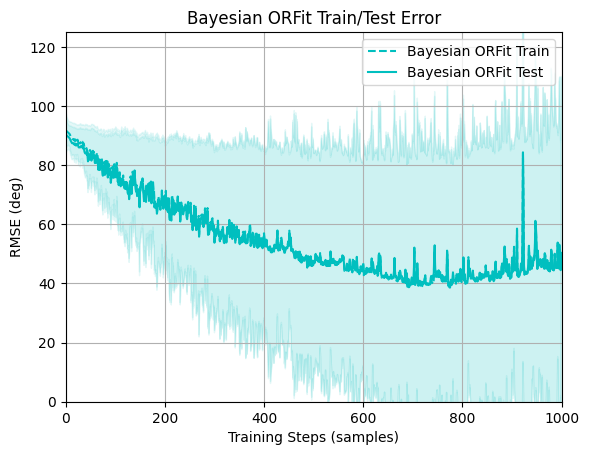

In [93]:
fig, ax = plt.subplots()
b_orfit_result_dict = {
    'Bayesian ORFit Train': {
        'rmse': b_orfit_train_rmses,
        'rmse_std': b_orfit_train_stds,
        'color': 'c',
        'ls': '--',
    },
    'Bayesian ORFit Test': {
        'rmse': b_orfit_test_rmses,
        'rmse_std': b_orfit_test_stds,
        'color': 'c',
        'ls': '-',
    }
}
ax = plot_results(ax, b_orfit_result_dict, 'Bayesian ORFit Train/Test Error', legend_loc=1)